In [1]:
import pandas as pd
%matplotlib inline

# RDF Primer

The RDF data model represents a directed, labeled graph as a set of *triples*. A triple consists of a *subject* (node), a *predicate* (directed edge) and an *object* (node). We will interact with the graph by way of these triples

<img src="files/refresher.png">



# Analysis with Brick

One of the primary benefits of having a machine-readable representation of a building is the ability to build portable analytics. Rather than hard-coding the specific data streams and points from a building into an analytics script, we can discover that structure dynamically by querying the Brick model.

The goal of this part of the tutorial is to demonstrate how to write SPARQL queries that pull information from such graphs, and how to use these queries to write portable analytics.

To help guide the queries we want to write, we've rendered a simple visualization of how class instances are connected in our sample building Brick model. The below figure tells us:
- nodes of type `brick:VAV` have `feeds` relationships with nodes of type `brick:HVAC_Zone`
- nodes of type `brick:Room` have `isPartOf` relationships with nodes of type `brick:HVAC_Zone`

<img src="files/vavhvac.png">

Here is the full graph:

<img src="files/classgraph.png">

There are only a few types of relationships (edge labels) that Brick captures, but these are sufficient for what we need. Here's a brief recap:

- **Subcomponents**: `hasPart`/`isPartOf`. Used for mechanical composition, relating HVAC zones with physical spaces
- **Identifying flows**: `feeds`/`isFedBy`. Used for flows of water, electricity, air, etc.
- **Sensing + actuation**: `hasPoint`/`isPointOf`. Used for associating sensor, setpoints, statuses, commands, meters, etc with related equipment, locations, etc
- **Location**: `hasLocation`/`isLocationOf`. Identifies the physical location of something
- **Instantiation**: `type` (implicit in the graph above)

The way we write SPARQL queries is by considering the types of "things" we care about as well as the nature of the relationships between those things.

The first thing we do is set up our query environment. For convenience, we're using the SPARQL engine included in the RDFlib Python library. We provide a brief wrapper around that library for queries, which takes care of most of the boilerplate involved in SPARQL queries. The most important part of this boilerplate are the namespace abbreviations.

Recall that in the RDF data model, all nodes are either Literals (strings) or URIs. All URIs have a namespace: for example in the URI `https://brickschema.org/schema/1.0.1/Brick#VAV`, the namespace is `https://brickschema.org/schema/1.0.1/Brick#` and the "node" is `VAV`. For convenience, we will abbreviate the URI so we can write `brick:VAV` instead of `https://brickschema.org/schema/1.0.1/Brick#VAV`.

Here are the abbreviations we will use:

| Namespace | Usage | Abbreviation |
|-----------|-------|--------------|
| `https://brickschema.org/schema/1.0.1/Brick#` | Brick classes | `brick:` |
| `https://brickschema.org/schema/1.0.1/BrickFrame#` | Brick relationships | `bf:` |
| `http://www.w3.org/1999/02/22-rdf-syntax-ns#` | class instantiation | `rdf:` |
| `http://www.w3.org/2000/01/rdf-schema#` | subclassing | `rdfs:` |
| `http://example.com#` | Nodes in our building | `ex:` |

In [2]:
from query import BrickGraph
bldg = BrickGraph()

# SPARQL Queries

## Exploring a Brick Model

We begin by executing the 'identity' SPARQL query that lists all of the triples in our model. We have chosen the variable names `?sub` `?pred` `?obj` for clarity; the *position* of the variable within a SPARQL triple conveys its role, rather than the name. For example, because `?obj` is the third item in the SPARQL triple, we know it corresponds to a node in the graph.

In [3]:
rows = bldg.query("""select ?sub ?pred ?obj where {
?sub ?pred ?obj .
}""", fullURI=False)

# print the first 10 rows
for row in rows[:10]:
    print row

[u'brick:Luminance_Alarm', u'rdf:type', u'owl:Class']
[u'brick:Max_Discharge_Air_Static_Pressure_Setpoint', u'rdf:type', u'owl:Class']
[u'brick:Pressure_Sensor', u'rdfs:label', rdflib.term.Literal(u'Pressure Sensor', lang=u'en')]
[u'brick:Hot_Water_Discharge_Temperature_Sensor', u'rdfs:subClassOf', u'brick:Water_Discharge_Temperature_Sensor']
[u'brick:HWS_Disable_Hot_Water_System_Outside_Air_Temperature_Setpoint', u'rdf:type', u'owl:Class']
[u'brick:Return_Fan_Differential_Speed_Sensor', u'rdfs:label', rdflib.term.Literal(u'Return Fan Differential Speed Sensor', lang=u'en')]
[u'brick:AHU_Heat_Wheel_Supply_Air_Temperature_Sensor', u'rdfs:label', rdflib.term.Literal(u'AHU Heat Wheel Discharge Air Temperature Sensor', lang=u'en')]
[u'brick:Economizer', u'rdfs:label', rdflib.term.Literal(u'Economizer', lang=u'en')]
[u'brick:AHU_Outside_Air_Temperature_High_Reset_Setpoint', u'rdfs:subClassOf', u'brick:Outside_Air_Temperature_High_Reset_Setpoint']
[u'brick:Power_Loss', u'rdfs:subClassOf', u'

We can see the node/edge/node construction in the returned triples.

**Listing Instances**

Let's amend this query so it starts giving us some more useful information. To start, let's list all of the VAVs in the building. To do this, we want to find all nodes that have a `rdf:type` edge (which indicates instantiation) to the `brick:VAV` node which represents the Brick VAV class. In the corresponding triple, we will put `rdf:type` in the "predicate" slot and `brick:VAV` in the "object" slot. In the subject slot, we will place a variable that will be populated when the query executes:

```sparql
?vav rdf:type brick:VAV
```

This corresponds to finding instances of the following subgraph:

<img src="files/vavclassq.png">

In [4]:
rows = bldg.query("""select ?vav where {
?vav rdf:type brick:VAV .
}""", fullURI=False)
for row in rows:
    print '?vav =',row[0]

?vav = ex:VAV_RM-1100A
?vav = ex:VAV_RM-2150
?vav = ex:VAV_RM-1100D


**Listing Neighbors**

A natural question when interacting with a new Brick model is what kind of information is associated with a particular VAV. We can express this as a SPARQL query by seeing which triples exist that have a VAV as the subject.

```sparql
ex:VAV_RM-1100D   ?pred   ?obj 
```

This corresponds to finding instances of the following subgraph:

<img src="files/vavneighbor.png">

In [5]:
rows = bldg.query("""select ?pred ?obj where {
ex:VAV_RM-2150 ?pred ?obj .
}""", fullURI=False)
for row in rows:
    print 'ex:VAV_RM-2150 has edge', row[0], 'to', row[1]

ex:VAV_RM-2150 has edge rdf:type to brick:VAV
ex:VAV_RM-2150 has edge bf:feeds to ex:RM-2150


**Listing Types**

The above queries work well if we know the exact classes instantiated in our Brick model. If we don't have this information and want to discover it, we can leverage Brick's class hierarchy.

<img src="files/tempsensorclass.png">

A common use case is finding which kinds of temperature sensors exist in the Brick model. The basic form of this uses both the `rdf:type` relationship (instantiation) and the `rdfs:subClassOf` relationship. By default, mentioning a predicate only traverses a single edge in the graph. We use SPARQL's `*` operator to match "0 or more" instances of an edge to transparently query more than one level of the hierarchy. SPARQL also provides a `+` operator to match "1 or more" edges.


This matches instances that are *immediate* subclasses of `brick:Temperature_Sensor`
```sparql
?sensor   rdf:type/rdfs:subClassOf    brick:Temperature_Sensor
```

This matches instances of `brick:Temperature_Sensor` as well as instances of *any* subclass of `brick:Temperature_Sensor`
```sparql
?sensor   rdf:type/rdfs:subClassOf*    brick:Temperature_Sensor
```

This query corresponds to the following subgraph in the case of Zone Air Temperature Sensors

<img src="files/tempsensorquery.png">

We can now run this query on our real Brick model to see what flavors of Temperature Sensor exist

In [6]:
rows = bldg.query("""select ?sensor ?class where {
?sensor rdf:type ?class .
?class rdfs:subClassOf* brick:Temperature_Sensor .
}""", fullURI=False)
for row in rows:
    print row[0], 'is an instance of', row[1]

ex:BLDA.AH1.CHWR2-T is an instance of brick:Chilled_Water_Return_Temperature_Sensor
ex:BLDA.AH1.CHWR1-T is an instance of brick:Chilled_Water_Return_Temperature_Sensor


If we are not interested in the intermediate class name, we can combine the expression of the `rdf:type` and `rdfs:subClassOf*` predicates using the `/` SPARQL operator:

In [7]:
rows = bldg.query("""select ?sensor where {
?sensor rdf:type/rdfs:subClassOf* brick:Temperature_Sensor .
}""", fullURI=False)
for row in rows:
    print row[0], 'is an instance of a subclass of Temperature_Sensor'

ex:BLDA.AH1.CHWR2-T is an instance of a subclass of Temperature_Sensor
ex:BLDA.AH1.CHWR1-T is an instance of a subclass of Temperature_Sensor


## Cross-Subsystem Queries

One of the main benefits of Brick is its ability to represent multiple building subsystems and query across them. We will explore these capabilities of Brick through the implementation of two analytics applications:
- Stuck Damper Detection
- Simultaneous Heating and Cooling Detection

The point of these explorations is not to implement cutting-edge fault detection/diagnosis algorithms, but rather to illustrate how Brick can make it easier to find the relevant data streams and make an implementation portable across buildings.

### Stuck Damper Detection

One method of detecting stuck dampers is to look at the difference between the supply air flow sensor and setpoint for a VAV.

- If the measured air flow is within some delta of the air flow setpoint, then the damper is fine
- Else, it might be broken

First, we write the Brick query(ies) to extract the relevant data streams: namely, the supply air flow sensor and supply air flow setpoint for each VAV in our building. In addition to the names of those points, we also extract from the Brick model some "timeseries identifier" that will point us to where we can obtain the actual data. Here, we use the `brick:hasUuid` relationship which points to an RDF literal corresponding to the name of a CSV data file.

Lets progressively build up the query. First, lets begin by identifying all the VAVs in the building:

```sparql
?vav   rdf:type    brick:VAV .
```

We will then identify the supply air flow setpoints and sensors using the `rdf:type` relationship, and because they measure an aspect of a VAV, we know they will be related to a VAV using the `isPointOf` relationship.

```sparql
?setpoint   rdf:type     brick:Supply_Air_Flow_Setpoint .
?sensor     rdf:type     brick:Supply_Air_Flow_Sensor .
?setpoint   bf:isPointOf brick:VAV .
?sensor     bf:isPointOf brick:VAV .
```

Lastly, we pull out the UUIDs for the timeseries

```sparql
?setpoint   brick:hasUuid  ?setpoint_uuid .
?sensor     brick:hasUuid  ?sensor_uuid .
```

In [8]:
rows = bldg.query("""select ?vav ?sensor ?setpoint ?sensor_uuid ?setpoint_uuid where {
?vav       rdf:type     brick:VAV .
?setpoint  rdf:type     brick:Supply_Air_Flow_Setpoint .
?sensor    rdf:type     brick:Supply_Air_Flow_Sensor .
?setpoint  bf:isPointOf ?vav .
?sensor  bf:isPointOf ?vav .
?setpoint   brick:hasUuid  ?setpoint_uuid .
?sensor     brick:hasUuid  ?sensor_uuid .
}""", fullURI=False)

# build a simple associative structure for the VAV points
vavs = {}
for row in rows:
    vavs[row[0]] = {'setpoint': row[4], 'sensor': row[3]}
print vavs

{u'ex:VAV_RM-1100D': {'setpoint': rdflib.term.Literal(u'36'), 'sensor': rdflib.term.Literal(u'37')}, u'ex:VAV_RM-2150': {'setpoint': rdflib.term.Literal(u'49'), 'sensor': rdflib.term.Literal(u'50')}, u'ex:VAV_RM-1100A': {'setpoint': rdflib.term.Literal(u'24'), 'sensor': rdflib.term.Literal(u'25')}}


ex:VAV_RM-1100D has no faults
ex:VAV_RM-2150 has no faults
ex:VAV_RM-1100A has faults
                     value_setpoint  value_sensor
timestamp                                        
2017-08-01 13:00:00           600.0       303.455
2017-08-02 01:30:00           300.0        17.760
2017-08-02 13:00:00           600.0       295.385
2017-08-03 01:30:00             0.0        67.400
2017-08-04 13:00:00           600.0       308.045
2017-08-05 01:30:00             0.0       308.965
2017-08-07 06:50:00           300.0        14.035
2017-08-07 13:00:00           600.0       300.010


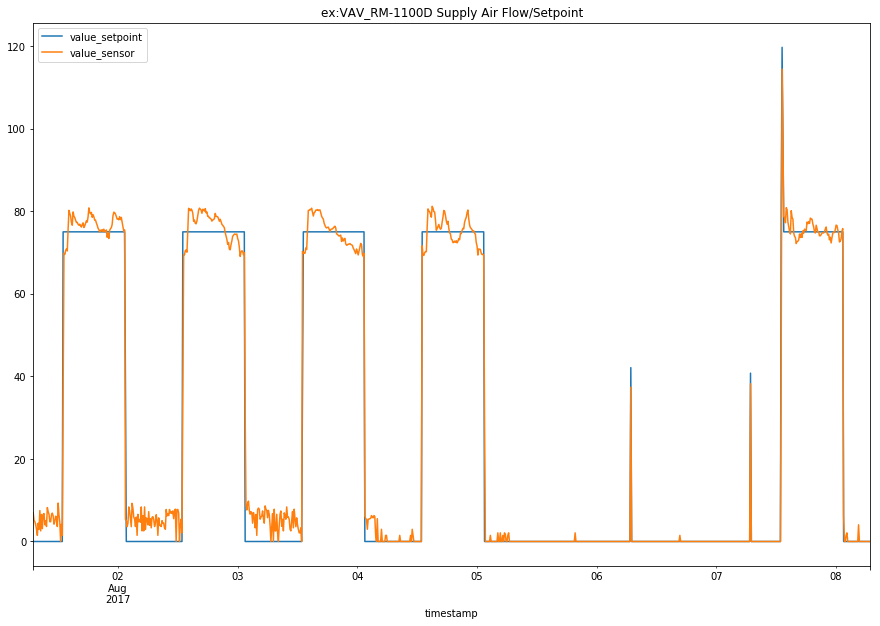

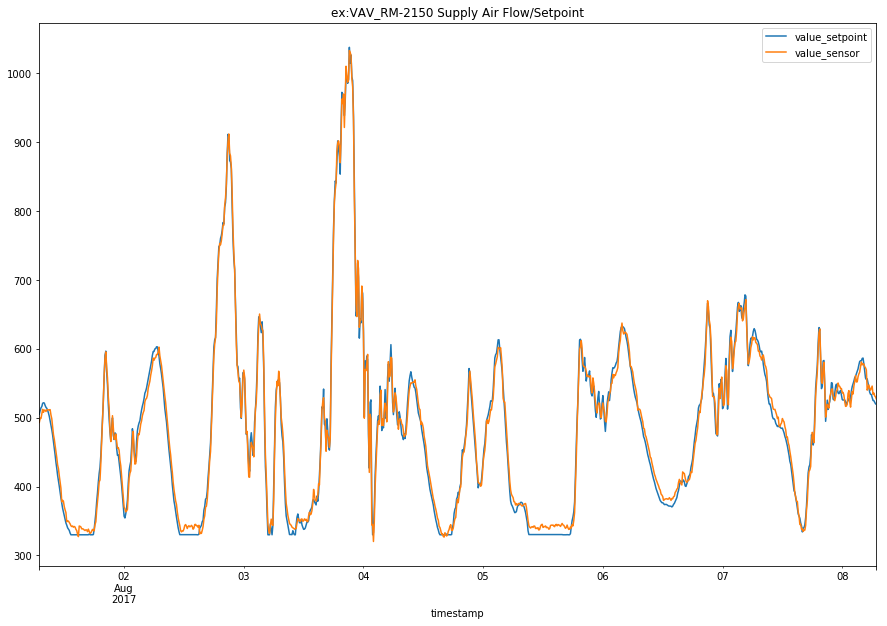

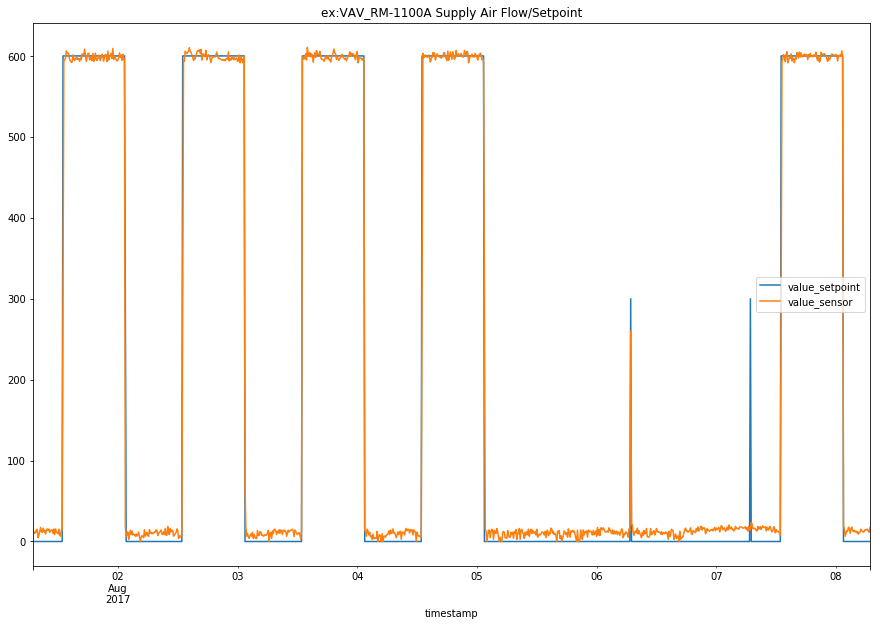

In [9]:
THRESHOLD = 50
for vavname, points in vavs.items():
    setpoint_df = pd.read_csv('data/{0}.csv'.format(points['setpoint']), usecols=['timestamp','value'])
    sensor_df = pd.read_csv('data/{0}.csv'.format(points['sensor']), usecols=['timestamp','value'])
    
    # parse timestamps
    setpoint_df = setpoint_df.set_index(pd.to_datetime(setpoint_df.pop('timestamp')))
    sensor_df = sensor_df.set_index(pd.to_datetime(sensor_df.pop('timestamp')))
    
    # resample 10-min mean
    setpoint_df = setpoint_df.resample('10T').mean()
    sensor_df = sensor_df.resample('10T').mean()
    
    # join the dataframes together so we can compare the values easier
    vav_df = setpoint_df.join(sensor_df, lsuffix='_setpoint', rsuffix='_sensor')
    ax = vav_df.plot(figsize=(15,10))
    ax.set_title('{0} Supply Air Flow/Setpoint'.format(vavname))
    
    # find datapoints where the difference between setpoint and sensor is greater than the threshold
    broken = vav_df[(vav_df['value_setpoint'] - vav_df['value_sensor']).abs() > THRESHOLD]
    if len(broken) > 0:
        print vavname, 'has faults'
        print broken
    else:
        print vavname,'has no faults'